In [1]:
pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import yaml
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels_dir = os.path.join(self.root_dir, 'labels')
        self.images_dir = os.path.join(self.root_dir, 'images')
        self.image_files = [f for f in os.listdir(self.images_dir) if os.path.isfile(os.path.join(self.images_dir, f))]
        self.label_files = [f for f in os.listdir(self.labels_dir) if os.path.isfile(os.path.join(self.labels_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        label_name = os.path.join(self.labels_dir, self.label_files[idx])

        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        with open(label_name, 'r') as file:
            line = file.readline().strip()
            label = int(line.split()[0])

        return image, label

In [6]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

In [7]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogleNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(480, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [8]:
with open('/content/drive/MyDrive/CSE 575 Project/archive/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize datasets and data loaders
train_dataset = CustomDataset(root_dir='/content/drive/MyDrive/CSE 575 Project/archive/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomDataset(root_dir='/content/drive/MyDrive/CSE 575 Project/archive/valid', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = CustomDataset(root_dir='/content/drive/MyDrive/CSE 575 Project/archive/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
model = GoogleNet(data['nc']).to(device)
criterion = nn.CrossEntropyLoss()
model.dropout = nn.Dropout(0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
num_epochs = 20
inception_train_accuracies = []

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    inception_train_accuracies.append(epoch_accuracy)

    print(f"Epoch: {epoch}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch: 0/20, Training Loss: 1.5093, Accuracy: 0.5888
Epoch: 1/20, Training Loss: 1.3340, Accuracy: 0.6302
Epoch: 2/20, Training Loss: 1.3206, Accuracy: 0.6361
Epoch: 3/20, Training Loss: 1.3442, Accuracy: 0.6331
Epoch: 4/20, Training Loss: 1.3085, Accuracy: 0.6302
Epoch: 5/20, Training Loss: 1.2980, Accuracy: 0.6391
Epoch: 6/20, Training Loss: 1.2841, Accuracy: 0.6361
Epoch: 7/20, Training Loss: 1.2817, Accuracy: 0.6391
Epoch: 8/20, Training Loss: 1.2375, Accuracy: 0.6331
Epoch: 9/20, Training Loss: 1.2862, Accuracy: 0.6450
Epoch: 10/20, Training Loss: 1.2130, Accuracy: 0.6361
Epoch: 11/20, Training Loss: 1.2470, Accuracy: 0.6450
Epoch: 12/20, Training Loss: 1.2448, Accuracy: 0.6331
Epoch: 13/20, Training Loss: 1.2835, Accuracy: 0.6213
Epoch: 14/20, Training Loss: 1.2699, Accuracy: 0.6391
Epoch: 15/20, Training Loss: 1.2242, Accuracy: 0.6361
Epoch: 16/20, Training Loss: 1.1739, Accuracy: 0.6450
Epoch: 17/20, Training Loss: 1.2011, Accuracy: 0.6420
Epoch: 18/20, Training Loss: 1.2144, A

In [11]:
import time

model.eval()
correct = 0
total = 0
total_inference_time = 0  # To track total inference time
num_batches = 0  # To track the number of batches processed

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        start_time = time.time()  # Start time measurement
        outputs = model(images)
        inference_time = time.time() - start_time  # Calculate inference time for this batch

        total_inference_time += inference_time
        num_batches += 1

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

if total > 0:
    print(f"Accuracy on test set: {(100 * correct / total):.2f}%")
else:
    print("No data processed.")

if num_batches > 0:
    average_inference_time = total_inference_time / num_batches
    print(f"Average inference time per batch (CUDA): {average_inference_time:.4f} seconds")
else:
    print("No batches processed.")

Accuracy on test set: 23.96%
Average inference time per batch (CUDA): 0.0043 seconds


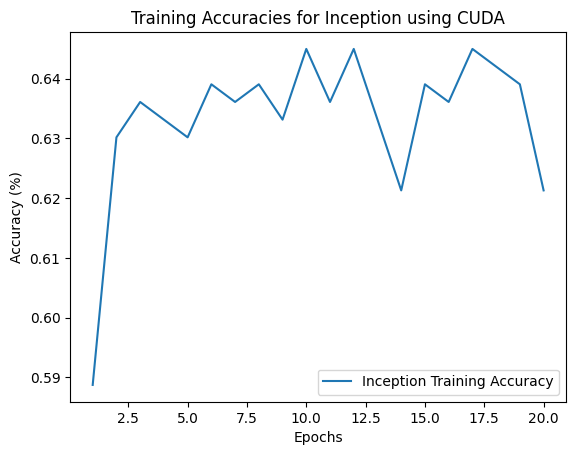

In [12]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, inception_train_accuracies, label='Inception Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracies for Inception using CUDA')
plt.legend()
plt.show()
